## Imports and Config

In [3]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import keras_cv
import keras
import keras.backend as K
import tensorflow as tf
import tensorflow_io as tfio

import numpy as np 
import pandas as pd

from glob import glob
from tqdm import tqdm

import librosa
import IPython.display as ipd
import librosa.display as lid

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split

cmap = mpl.cm.get_cmap('coolwarm')

<ipython-input-3-7fcf161c5c89>:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


In [ ]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

In [6]:
# Reproducibility
tf.keras.utils.set_random_seed(42)

# Dataset Path
BASE_PATH = '/kaggle/input/birdclef-2021'

## Train/Test Metadata

In [7]:
# Path to the uploaded file
metadata_dir = '/kaggle/input/hackathon-1-birdclef-train-test-metadata/'

train_path = f'{metadata_dir}/to_predict__train.csv'
test_path = f'{metadata_dir}/to_predict__test.csv'

# Load the CSV into a DataFrame
df_train_ = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Display the first few rows
df_train_.head()

,primary_label,common_name,scientific_name,latitude,longitude,date,season,url,filename
0,gnwtea,Green-winged Teal,Anas crecca,55.50420,9.73640,2020-05-01,Spring,https://www.xeno-canto.org/552779,XC552779.ogg
1,grasal1,Grayish Saltator,Saltator coerulescens,16.78120,-88.45870,1994-03-16,Spring,https://www.xeno-canto.org/28597,XC28597.ogg
2,grasal1,Grayish Saltator,Saltator coerulescens,-32.12660,-60.66870,2005-11-12,Fall,https://www.xeno-canto.org/563285,XC563285.ogg
3,grasal1,Grayish Saltator,Saltator coerulescens,9.98090,-84.07890,2019-07-13,Summer,https://www.xeno-canto.org/499849,XC499849.ogg
4,grnjay,Green Jay,Cyanocorax yncas,4.70138,-75.64108,2009-03-13,Spring,https://www.xeno-canto.org/244732,XC244732.ogg


In [41]:
class CFG:
    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 64
    
    # Audio duration, sample rate, and length
    duration = 15 # second
    sample_rate = 32000
    audio_len = duration*sample_rate
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    
    # Number of epochs, model name
    epochs = 10
    preset = 'efficientnetv2_b2_imagenet'
    
    # Data augmentation parameters
    augment=True

    # Class Labels for BirdCLEF 24
    # class_names = sorted(os.listdir('/kaggle/input/birdclef-2021/train_short_audio/'))
    class_names = list(df_train_['primary_label'].unique())
    num_classes = 5
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

In [46]:
CFG.class_names
CFG.label2name

{0: 'gnwtea', 1: 'grasal1', 2: 'grnjay', 3: 'reevir1', 4: 'heptan'}

In [50]:
df_train__primary_labels = ['gnwtea', 'grasal1', 'grnjay', 'reevir1', 'heptan']

# [for l in df_train__primary_labels  CFG.class_names]

In [51]:
df_test.nunique()

primary_label       5
common_name         5
scientific_name     5
latitude           41
longitude          41
date               43
season              4
url                45
filename           45
dtype: int64

In [52]:
df_train_['filepath'] = f'{BASE_PATH}/train_short_audio/' + df_train_.primary_label +'/' + df_train_.filename
df_train_['target'] = df_train_.primary_label.map(CFG.name2label)
df_train_['filename'] = df_train_.filepath.map(lambda x: x.split('/')[-1])
df_train_['xc_id'] = df_train_.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

df_train_.head(2)

,primary_label,common_name,scientific_name,latitude,longitude,date,season,url,filename,filepath,target,xc_id
0,gnwtea,Green-winged Teal,Anas crecca,55.5042,9.7364,2020-05-01,Spring,https://www.xeno-canto.org/552779,XC552779.ogg,/kaggle/input/birdclef-2021/train_short_audio/...,0,XC552779
1,grasal1,Grayish Saltator,Saltator coerulescens,16.7812,-88.4587,1994-03-16,Spring,https://www.xeno-canto.org/28597,XC28597.ogg,/kaggle/input/birdclef-2021/train_short_audio/...,1,XC28597


## Utils

In [53]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio, 
                                          sr=CFG.sample_rate, 
                                          n_mels=256,
                                          n_fft=2048,
                                          hop_length=512,
                                          fmax=CFG.fmax,
                                          fmin=CFG.fmin,
                                         )
    spec = librosa.power_to_db(spec, ref=1.0)
    min_ = spec.min()
    max_ = spec.max()
    if max_ != min_:
        spec = (spec - min_)/(max_ - min_)
    return spec

def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name}'
    # Read audio file
    audio, sr = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0],
                 color= cmap(0.1))
    # Specplot
    lid.specshow(spec, 
                 sr = CFG.sample_rate, 
                 hop_length=512,
                 n_fft=2048,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time', 
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

# Audio:


# Visualization:


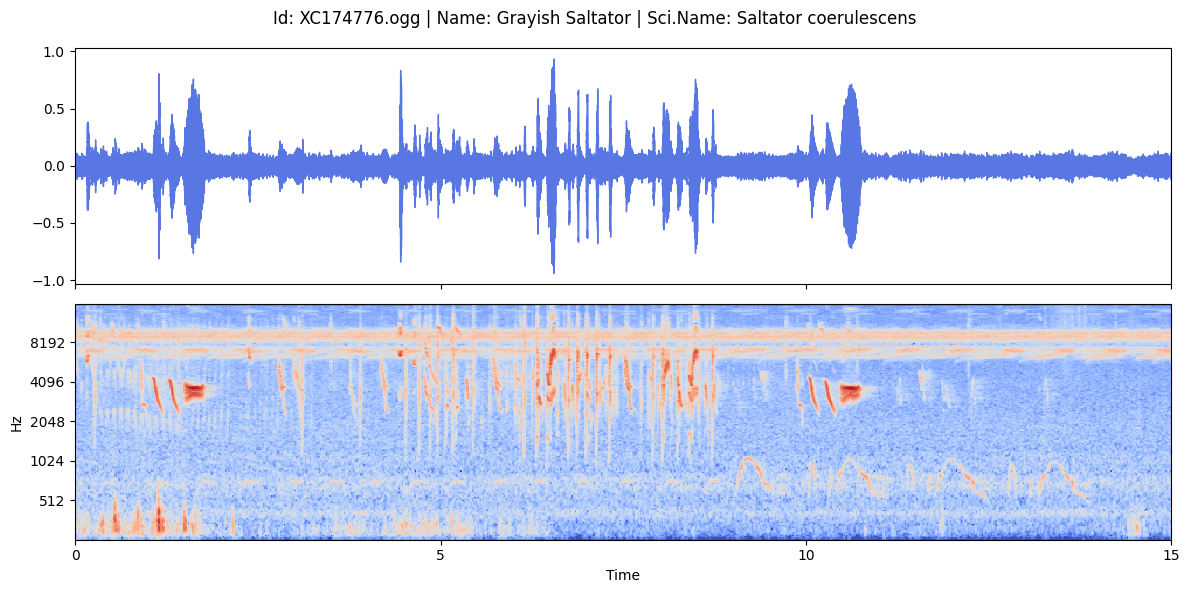

In [54]:
row = df_train_.iloc[35]

# Display audio
display_audio(row)

## Split Data: Train + Validation

In [55]:
df_train, df_val = train_test_split(df_train_, test_size=0.2)

print(f"Num Train: {len(df_train)} | Num Valid: {len(df_val)}")

Num Train: 676 | Num Valid: 170


## Data Loader

### Decoders

In [59]:
# Decodes Audio
def build_decoder(with_labels=True, dim=1024):
    def get_audio(filepath):
        file_bytes = tf.io.read_file(filepath)
        audio = tfio.audio.decode_vorbis(file_bytes)  # decode .ogg file
        audio = tf.cast(audio, tf.float32)
        if tf.shape(audio)[1] > 1:  # stereo -> mono
            audio = audio[..., 0:1]
        audio = tf.squeeze(audio, axis=-1)
        return audio

    def crop_or_pad(audio, target_len, pad_mode="constant"):
        audio_len = tf.shape(audio)[0]
        diff_len = abs(
            target_len - audio_len
        )  # find difference between target and audio length
        if audio_len < target_len:  # do padding if audio length is shorter
            pad1 = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            pad2 = diff_len - pad1
            audio = tf.pad(audio, paddings=[[pad1, pad2]], mode=pad_mode)
        elif audio_len > target_len:  # do cropping if audio length is larger
            idx = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            audio = audio[idx : (idx + target_len)]
        return tf.reshape(audio, [target_len])

    def apply_preproc(spec):
        # Standardize
        mean = tf.math.reduce_mean(spec)
        std = tf.math.reduce_std(spec)
        spec = tf.where(tf.math.equal(std, 0), spec - mean, (spec - mean) / std)

        # Normalize using Min-Max
        min_val = tf.math.reduce_min(spec)
        max_val = tf.math.reduce_max(spec)
        spec = tf.where(
            tf.math.equal(max_val - min_val, 0),
            spec - min_val,
            (spec - min_val) / (max_val - min_val),
        )
        return spec

    def get_target(target):
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, CFG.num_classes), tf.float32)
        target = tf.reshape(target, [CFG.num_classes])
        return target

    def decode(path):
        # Load audio file
        audio = get_audio(path)
        # Crop or pad audio to keep a fixed length
        audio = crop_or_pad(audio, dim)
        # Audio to Spectrogram
        spec = keras.layers.MelSpectrogram(
            num_mel_bins=CFG.img_size[0],
            fft_length=CFG.nfft,
            sequence_stride=CFG.hop_length,
            sampling_rate=CFG.sample_rate,
        )(audio)
        # Apply normalization and standardization
        spec = apply_preproc(spec)
        # Spectrogram to 3 channel image (for imagenet)
        spec = tf.tile(spec[..., None], [1, 1, 3])
        spec = tf.reshape(spec, [*CFG.img_size, 3])
        return spec

    def decode_with_labels(path, label):
        label = get_target(label)
        return decode(path), label

    return decode_with_labels if with_labels else decode


### Augmenters

In [60]:
def build_augmenter():
    augmenters = [
        keras_cv.layers.MixUp(alpha=0.4),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.12)), # time-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # freq-masking
    ]
    
    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.35:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]
    
    return augment

### Data Pipeline

In [64]:
def build_dataset(paths, labels=None, batch_size=32, 
                  decode_fn=None, augment_fn=None, cache=True,
                  augment=False, shuffle=2048):

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None, dim=CFG.audio_len)

    if augment_fn is None:
        augment_fn = build_augmenter()
        
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths,) if labels is None else (paths, labels)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache() if cache else ds
    if shuffle:
        opt = tf.data.Options()
        ds = ds.shuffle(shuffle, seed=42)
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

### Build Train and Valid Dataloaders

In [65]:
# Train
train_paths = df_train.filepath.values
train_labels = df_train.target.values
train_ds = build_dataset(train_paths, train_labels, batch_size=CFG.batch_size,
                         shuffle=True, augment=CFG.augment)

# Valid
valid_paths = df_val.filepath.values
valid_labels = df_val.target.values
valid_ds = build_dataset(valid_paths, valid_labels, batch_size=CFG.batch_size,
                         shuffle=False, augment=False)

## Visualization

In [66]:
def plot_batch(batch, row=3, col=3, label2name=None,):
    """Plot one batch data"""
    if isinstance(batch, tuple) or isinstance(batch, list):
        specs, tars = batch
    else:
        specs = batch
        tars = None
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        lid.specshow(np.array(specs[idx, ..., 0]), 
                     n_fft=CFG.nfft, 
                     hop_length=CFG.hop_length, 
                     sr=CFG.sample_rate,
                     x_axis='time',
                     y_axis='mel',
                     cmap='coolwarm')
        if tars is not None:
            label = tars[idx].numpy().argmax()
            name = label2name[label]
            plt.title(name)
    plt.tight_layout()
    plt.show()

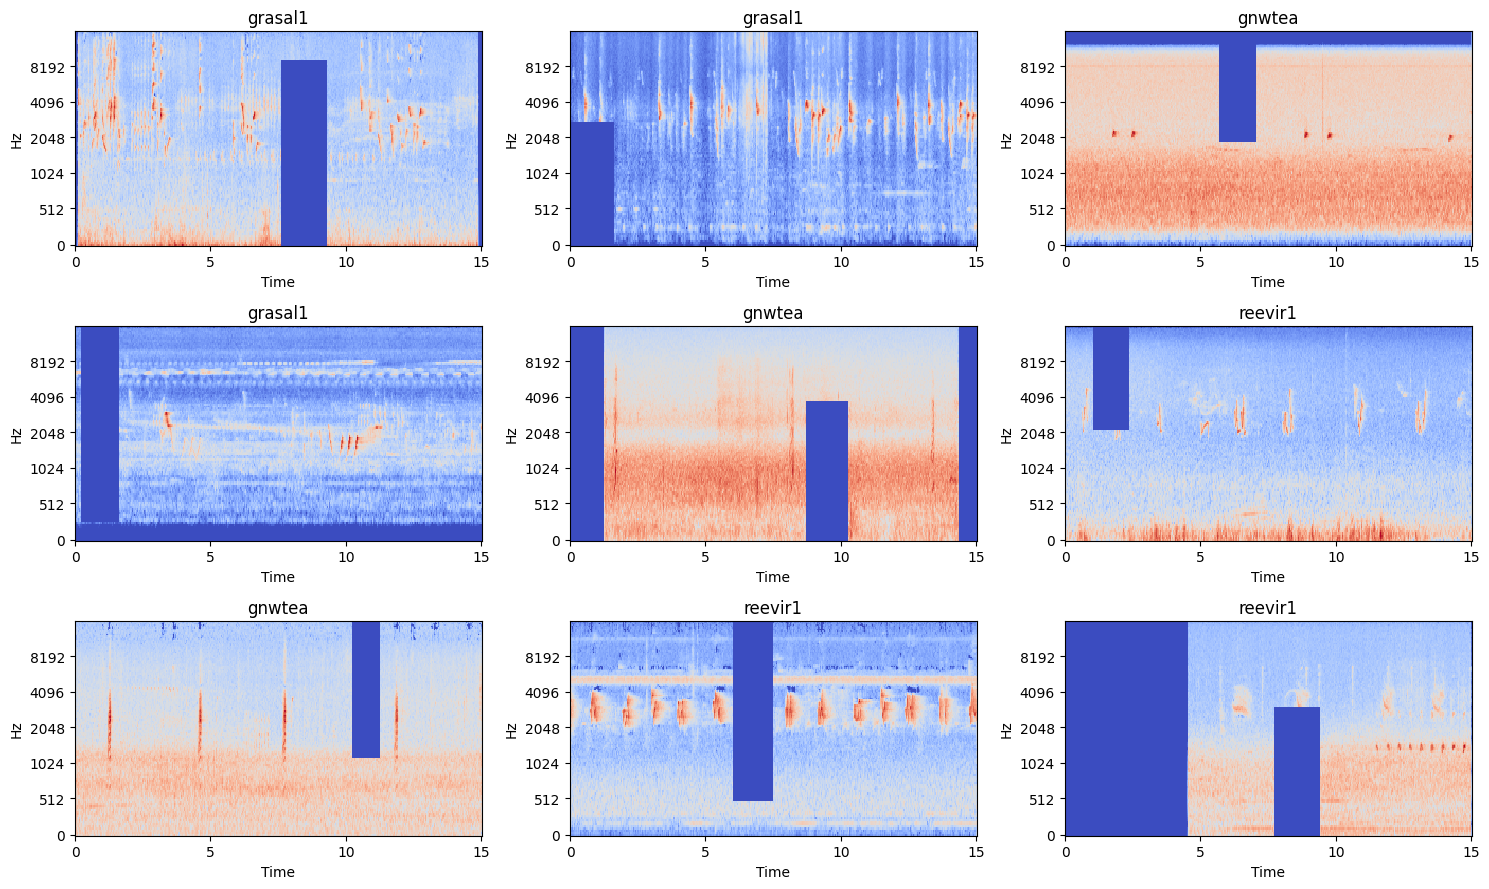

In [24]:
sample_ds = train_ds.take(100)
batch = next(iter(sample_ds))
plot_batch(batch, label2name=CFG.label2name)

## 🤖 Modeling

In [67]:
# Create an input layer for the model
inp = keras.layers.Input(shape=(None, None, 3))
# Pretrained backbone
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
    CFG.preset,
)
out = keras_cv.models.ImageClassifier(
    backbone=backbone,
    num_classes=CFG.num_classes,
    name="classifier"
)(inp)


# Build model
model = keras.models.Model(inputs=inp, outputs=out)
# Compile model with optimizer, loss and metrics
model.compile(optimizer="adam",
              loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
              metrics=[keras.metrics.CategoricalAccuracy(name="acc")]
              # metrics=[keras.metrics.AUC(name='auc')],
              # metrics=[keras.metrics.Accuracy(name='acc')],

              # loss="categorical_crossentropy", 
              # metrics=["accuracy"]
             )

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classifier (ImageClassifier)         │ (None, 5)                   │       8,776,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,776,419 (33.48 MB)

 Trainable params: 8,694,131 (33.17 MB)

 Non-trainable params: 82,288 (321.44 KB)

## LR Schedule

In [72]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 8e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

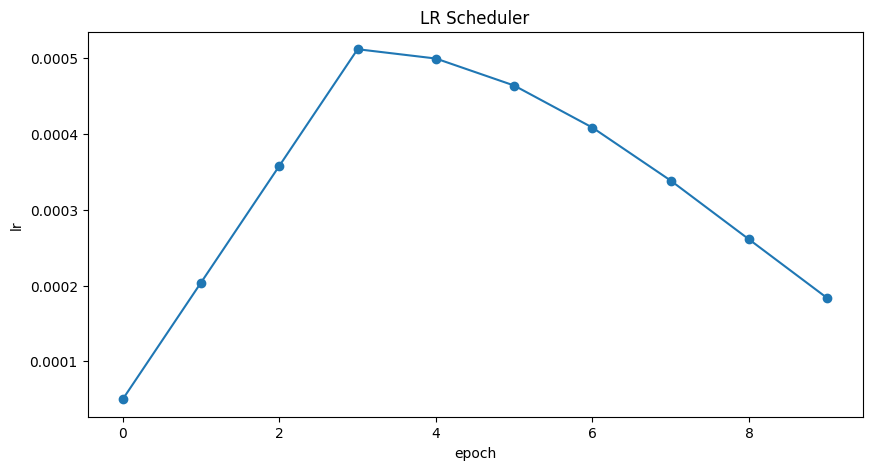

In [69]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

## Model Checkpoint

In [73]:
ckpt_cb = keras.callbacks.ModelCheckpoint('efficientnetv2_b2_best.keras',
                                         #"best_model.weights.h5",
                                         # monitor='val_auc',
                                          monitor='val_acc', 
                                          save_best_only=True, 
                                          save_weights_only=False, 
                                          mode='max')

## 🚀 Training

In [74]:
history = model.fit(
    train_ds, 
    validation_data=valid_ds, 
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb], 
    verbose=1
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 180s 6s/step - acc: 0.2273 - loss: 1.6075 - val_acc: 0.0312 - val_loss: 1.6752 - learning_rate: 5.0000e-05
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - acc: 0.5458 - loss: 1.4502 - val_acc: 0.3047 - val_loss: 1.6043 - learning_rate: 2.0400e-04
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - acc: 0.6992 - loss: 1.1246 - val_acc: 0.3047 - val_loss: 1.6382 - learning_rate: 3.5800e-04
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - acc: 0.7610 - loss: 0.7594 - val_acc: 0.3047 - val_loss: 1.7594 - learning_rate: 5.1200e-04
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - acc: 0.8796 - loss: 0.4717 - val_acc: 0.3281 - val_loss: 1.6665 - learning_rate: 4.9972e-04
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - acc: 0.9160 - loss: 0.3712 - val_acc: 0.5156 - val_loss: 1.2769 - learning_rate: 4.6406e-04
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - acc: 0.9618 - loss: 0.2614 - val_acc: 0.7109 - val_loss: 0.9104 - learning_rate: 4.

### Result Summary

In [76]:
# best_epoch = np.argmax(history.history["val_auc"])
# best_score = history.history["val_auc"][best_epoch]
# print('>>> Best AUC: ', best_score)
# print('>>> Best Epoch: ', best_epoch + 1)


best_epoch = np.argmax(history.history["val_acc"])
best_score = history.history["val_acc"][best_epoch]
print('>>> Best Val Accuracy: ', best_score)
print('>>> Best Epoch: ', best_epoch + 1)

>>> Best Val Accuracy:  0.8203125
>>> Best Epoch:  10


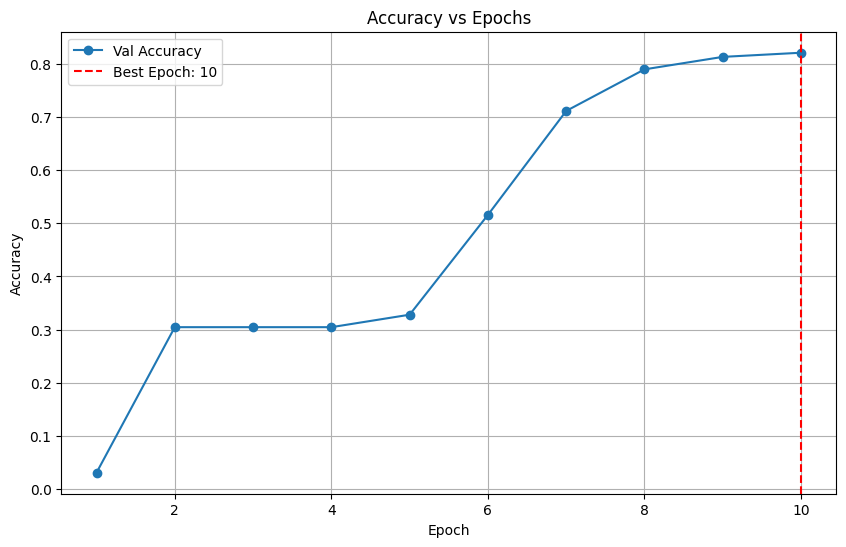

In [77]:
plt.figure(figsize=(10, 6))

# plt.plot(history.history["val_acc"], label="Train Accuracy", marker="o")
# plt.axvline(x=best_epoch, color='r', linestyle="--", label=f"Best Epoch: {best_epoch + 1}")
# Добавляем range(1, ...) для оси x
epochs = range(1, len(history.history["val_acc"]) + 1)
plt.plot(epochs, history.history["val_acc"], label="Val Accuracy", marker="o")
# Смещаем вертикальную линию на соответствующую эпоху
plt.axvline(x=best_epoch + 1, color='r', linestyle="--", label=f"Best Epoch: {best_epoch + 1}")


plt.title("Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

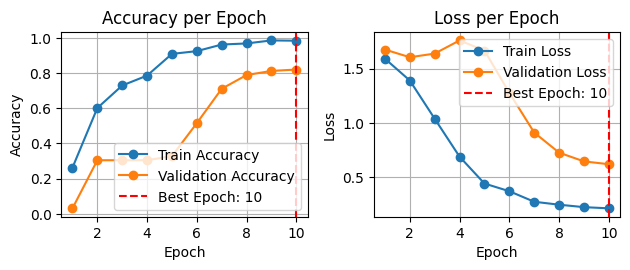

Best epoch: 10, Best Validation Accuracy: 0.8203


In [78]:
plt.subplot(2, 2, 1)
plt.plot(epochs, history.history["acc"], label="Train Accuracy", marker="o")
plt.plot(epochs, history.history["val_acc"], label="Validation Accuracy", marker="o")
plt.axvline(best_epoch + 1, color='r', linestyle='--', label=f"Best Epoch: {best_epoch + 1}")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(epochs, history.history["loss"], label="Train Loss", marker="o")
plt.plot(epochs, history.history["val_loss"], label="Validation Loss", marker="o")
plt.axvline(best_epoch + 1, color='r', linestyle='--', label=f"Best Epoch: {best_epoch + 1}")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


print(f"Best epoch: {best_epoch + 1}, Best Validation Accuracy: {best_score:.4f}")

In [80]:
# efficientnetv2_b2

%cd /kaggle/working
from IPython.display import FileLink
# FileLink('best_model.weights.h5')
FileLink('efficientnetv2_b2_best.keras')

/kaggle/working


/kaggle/working/efficientnetv2_b2_best.keras